In [ ]:
# default_exp dewarp_spatial_transformer_training

In [ ]:
#export
from ocr.core import *
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from ocr.ocr_dataset_brno import brno_ocr_config
from pathlib import PosixPath
import cv2

In [ ]:
images_dir = brno_ocr_config.MAIN_DIR/'templates'/'templates'

In [ ]:
train_dir = PosixPath('../data/dewarp/brno_templates/')

### Training Transformation Example

In [ ]:
for im_path in images_dir.iterdir():
    img = open_image(im_path)
    img = img.resize((img.shape[0],) + (1000,724)).refresh()
    break

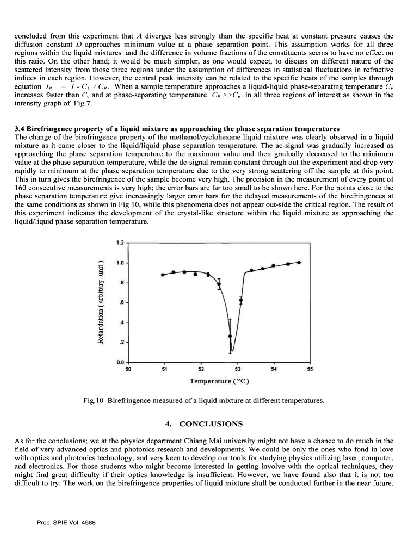

In [ ]:
img.show(figsize=(10,10))

In [ ]:
def rotate_image(image, angles):
    # if angle == tuple[1]: then applys input angle
    # if angle == tuple[2]: then applys random angle between two input angles
    angle = angles[0] if len(listify(angles)) == 1 else random.choice(list(range(*angles)))
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    out_im = cv2.warpAffine(image, M, (nW, nH), borderValue=(255,255,255))
    return cv2.resize(out_im, (w,h))

In [ ]:
#export
def opencv_transform(fun):
    def transform(x, **kwargs):
        x = (image2np(x)*255).astype(np.uint8)
        x = fun(x, **kwargs)
        return tensor(x/255.).permute(2,0,1)
    return transform

# gaussian_blur = TfmPixel(_gaussian_blur)
def random_affine_transform(angles, p=1.0):
    return RandTransform(tfm=TfmPixel(opencv_transform(rotate_image)), kwargs={'angles':angles}, p=p, resolved={}, do_run=True, is_random=True, use_on_y=False)

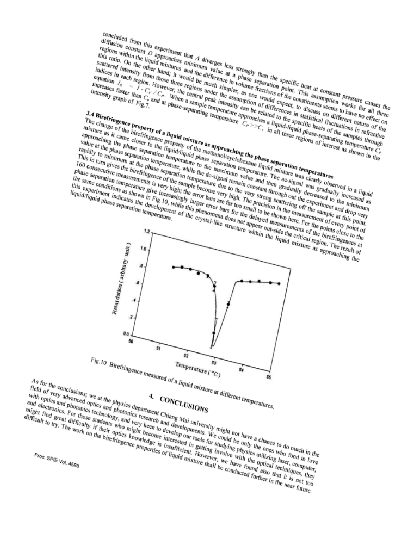

In [ ]:
im = img.apply_tfms([random_affine_transform(angles=(-20,20))])
im.show(figsize=(10,10))

### Make dataset

In [ ]:
def make_dataset(out_dir, size, num_elem=None): # size: tuple[2]
    im_paths = list(images_dir.iterdir())
    im_paths = im_paths if num_elem is None else im_paths[:num_elem]
    for im_path in progress_bar(im_paths):
        fn = str(im_path).split('/')[-1]
        im = open_image(im_path)
        im = im.resize((im.shape[0],) + size).refresh()
        im.save(out_dir/fn)

In [ ]:
w = 480
w = 640
size = (int(w*1.3), w)
# size = (224,224)
# make_dataset(train_dir, size, num_elem=None)

### Model

In [ ]:
class AffineMatrixPredictor(nn.Module):
    def __init__(self, nc=3*2, out_mult=1):
        super().__init__()
        self.out_mult = out_mult
        model = create_cnn_model(models.resnet18, nc=nc)
        self.body = model[0]
        self.head = model[1]
    
    def forward(self, x):
        x = self.body(x) #.detach()
        for name,f in self.head.named_children():
            if x.shape[0] == 1 and (name == '2' or name == '6'): continue
            x = f(x)
        return torch.tanh(x) * self.out_mult

In [ ]:
AffineMatrixPredictor(nc=1)(torch.zeros(2,3,100,100)).shape

torch.Size([2, 1])

### Custom Databunch

In [ ]:
class OpenCVTransform:
    def __init__(self, im_fun, px_fun):
        self.__name__ = 'OpenCVTransform'
        self.__annotations__ = {}
        self.im_fun, self.px_fun = im_fun, px_fun
    
    def __call__(self, x, **kwargs):
        for k,v in kwargs.items():
            kwargs[k] = [v[0]] if len(listify(v)) == 1 else [random.choice(list(range(v[0],v[1])))]
        
        if len(x.shape) > 2: # its an image
            self.x_kwargs = kwargs
            x = (image2np(x)*255).astype(np.uint8)
            x = self.im_fun(x, **kwargs)
            return tensor(x/255.).permute(2,0,1)
        else:
            return self.px_fun(x, **self.x_kwargs)
        
def opencv_transform(im_fun, px_fun):
    def transform(x, **kwargs):
        if len(x.shape) > 2: # its an image
            x = (image2np(x)*255).astype(np.uint8)
            x = im_fun(x, **kwargs)
            return tensor(x/255.).permute(2,0,1)
        else:
            return px_fun(x, **kwargs)
    return transform

In [ ]:
def rotate_image(image, angles):
    # if angle == tuple[1]: then applys input angle
    # if angle == tuple[2]: then applys random angle between two input angles
    angle = angles[0] if len(listify(angles)) == 1 else random.choice(list(range(*angles)))
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    out_im = cv2.warpAffine(image, M, (nW, nH), borderValue=(255,255,255))
    return cv2.resize(out_im, (w,h))

In [ ]:
def rotate_angle(orig_angle, angles): # same as in rotate_image
    angle = angles[0] if len(listify(angles)) == 1 else random.choice(list(range(*angles)))
    return orig_angle + angle

In [ ]:
#export
def random_affine_transform(angles, p=1.0):
    return RandTransform(tfm=TfmPixel(OpenCVTransform(rotate_image, rotate_angle)), kwargs={'angles':angles}, p=p, resolved={}, do_run=True, is_random=True, use_on_y=True)

In [ ]:
train_transforms = [
#     rand_zoom(scale=(.2,.8), p=1.),
    random_affine_transform(angles=(-20,20)),
#     symmetric_warp(magnitude=(-0.2, 0.2), p=1.),
#     brightness(change=(0.4, 0.6), p=0.8),
#     contrast(scale=(0.8,1.2), p=0.8)
]

valid_transforms = [
#     rand_zoom(scale=(.5,.8), p=1.),
    random_affine_transform(angles=(-20,20))
]
transforms = (train_transforms, valid_transforms)

In [ ]:
class TensorItem(ItemBase):
    def __init__(self, t):
        t = tensor(t).float()
        self.px,self.obj,self.data,self.shape = t,t,t,t.shape
        
    def clone(self): return self.__class__(self.px.clone())
    def __repr__(self): return f'{self.__class__.__name__} {self.obj}'
    def reconstruct(self, t): return t
    
    # added custom transformations (works only w/ TfmPixel transforms)
    def pixel(self, func, *args, **kwargs):
        self.px = func(self.px, *args, **kwargs)
        return self
    
    # ignore affine transformations
    def affine(self, func, *args, **kwargs): return self 
    
    def apply_tfms(self, tfms, **kwargs):
        x = self.clone()
        for tfm in tfms:
            x = tfm(x)
        return x.px.float()

In [ ]:
class TensorList(ItemList):
    def get(self, i): return TensorItem(self.items[i].float())
    def reconstruct(self, t, x): return TensorItem(t.float())

In [ ]:
class ImageTransformList(ImageList):
    "`ItemList` suitable for `Image` to `Image` tasks."
    _label_cls,_square_show,_square_show_res = ImageList,False,False

    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys`(targets)  on a figure of `figsize`."
        axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize)
        for i, (x,y) in enumerate(zip(xs,ys)): # Image, TensorItem
            y = float(y.data)
            x.show(ax=axs[i,0], title=f'original image', **kwargs)
            y_im = deepcopy(x).apply_tfms([random_affine_transform(angles=[-y])])
            y_im.show(ax=axs[i,1], title=f'rotated by {-y} angle', **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        title = 'Input / Prediction / Target'
        axs = subplots(len(xs), 3, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
        for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
            y = float(y.data)
            z = float(z.data)
            x.show(ax=axs[i,0], title=f'rotated image', **kwargs)
            y_im = deepcopy(x).apply_tfms([random_affine_transform(angles=[-y])])
            y_im.show(ax=axs[i,2], title=f'true, rotated by {-int(y)} angle', **kwargs)
            z_im = deepcopy(x).apply_tfms([random_affine_transform(angles=[-z])])
            z_im.show(ax=axs[i,1], title=f'pred, rotated by {-int(z)} angle', **kwargs)

In [ ]:
#export
def im2tensor_data_collate(batch:ItemsList, pad_idx:int=1)->Tensor:
    if isinstance(batch[0][1], int): return data_collate(batch)
    "Convert `batch` items to tensor data."
    data = to_data(batch) # list of (image, array) pairs
    max_x_w = max([image.shape[2] for image, y in data])
    max_x_h = max([image.shape[1] for image, y in data])
    max_y_len = max([len(y) for image, y in data])
    
    images = torch.zeros(len(batch), 3, max_x_h, max_x_w) + pad_idx
    ys = torch.zeros(len(batch), max_y_len)
    for i, (image, y) in enumerate(data):
        c,h,w = image.shape
        pad_h, pad_w = int((max_x_h-h)/2), int((max_x_w-w)/2)
        images[i, : , pad_h:max_x_h-pad_h , pad_w:max_x_w-pad_w ] = image
        y = tensor(listify(y)).view(-1)
        ys[i, :len(y)] = y
    return images, ys

In [ ]:
data = (ImageTransformList.from_folder(train_dir)
    .split_by_rand_pct(0.1, seed=42)
#     .split_none()
    .label_from_func(lambda _: torch.zeros(1), label_cls=TensorList)
    .transform(transforms, tfm_y=True)
    .databunch(bs=8, collate_fn=im2tensor_data_collate)
    .normalize(imagenet_stats)
)
data

ImageDataBunch;

Train: LabelList (1902 items)
x: ImageTransformList
Image (3, 832, 640),Image (3, 832, 640),Image (3, 832, 640),Image (3, 832, 640),Image (3, 832, 640)
y: TensorList
tensor([-5.]),tensor([1.]),tensor([-3.]),tensor([-18.]),tensor([-16.])
Path: ../data/dewarp/brno_templates;

Valid: LabelList (211 items)
x: ImageTransformList
Image (3, 832, 640),Image (3, 832, 640),Image (3, 832, 640),Image (3, 832, 640),Image (3, 832, 640)
y: TensorList
tensor([-14.]),tensor([-11.]),tensor([-3.]),tensor([15.]),tensor([19.])
Path: ../data/dewarp/brno_templates;

Test: None

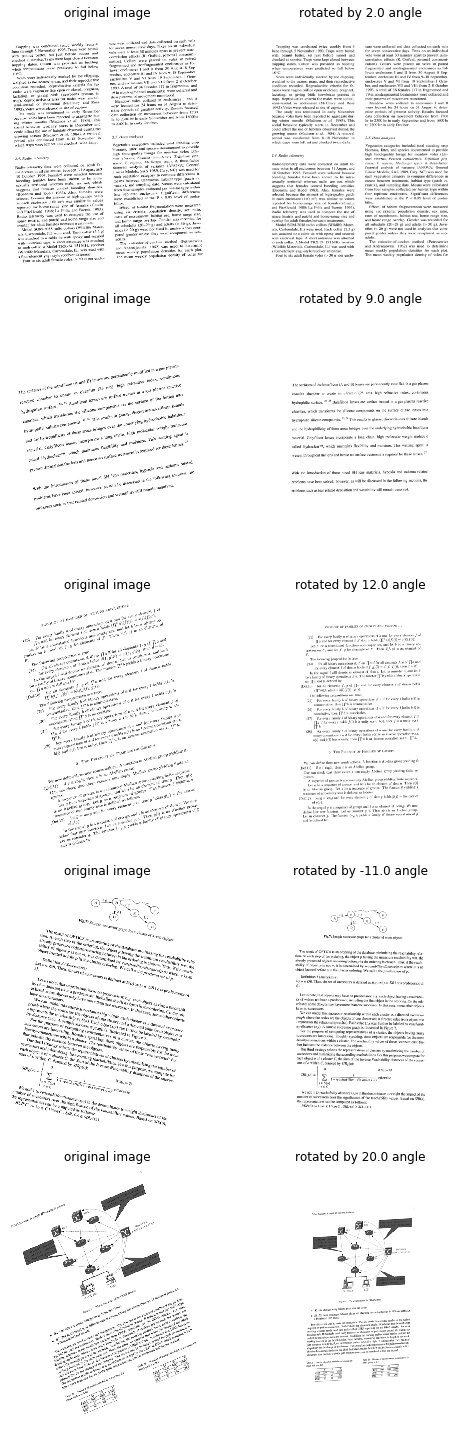

In [ ]:
data.show_batch()

### Training

In [ ]:
def MSE(y_pred, y_true):
    return MSELossFlat()(*prepare_loss(y_pred, y_true))

def SmoothL1(y_pred, y_true):
    return nn.SmoothL1Loss()(*prepare_loss(y_pred, y_true))

In [ ]:
def deactivate_batchnorm(m):
    if isinstance(m, nn.BatchNorm2d):
        m.reset_parameters()
        m.eval()
        with torch.no_grad():
            m.weight.fill_(1.0)
            m.bias.zero_()
            
class CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = create_cnn_model(models.resnet18, nc=1, pretrained=True)
        
    def forward(self, x):
        return self.cnn(x)
    
    def train(self, *args, **kwargs):
        self = super().train(*args, **kwargs)
        self.deactivate_batchnorm(self)
        return self
    
    def eval(self, *args, **kwargs):
        self = super().eval(*args, **kwargs)
        self.deactivate_batchnorm(self)
        return self
    
    @staticmethod
    def deactivate_batchnorm(m):
        if isinstance(m, nn.BatchNorm2d):
            m.reset_parameters()
            m.eval()
            with torch.no_grad():
                m.weight.fill_(1.0)
                m.bias.zero_()

In [ ]:
x = torch.randn(2,3,*size)
model = CnnModel()
# model = learner.model.cpu()
x.shape

torch.Size([2, 3, 832, 640])

In [ ]:
angle_range = 20 # +- this
prepare_loss = lambda y_pred, y_true: (y_pred.view(-1)/angle_range, y_true.view(-1)/angle_range)
# model = AffineMatrixPredictor(nc=1, out_mult=angle_range)
# model = create_cnn_model(models.resnet18, nc=1, pretrained=True)
model = CnnModel()
loss = SmoothL1

In [ ]:
learner = Learner(data, model, loss_func=loss, callback_fns=[ShowGraph], metrics=[mean_absolute_error])

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.028382,0.024829,3.519025,00:44


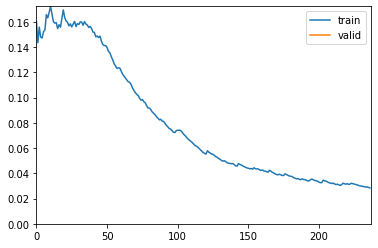

In [ ]:
learner.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.034646,0.010424,2.381151,00:44


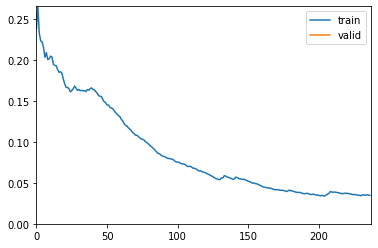

In [ ]:
learner.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.078099,0.039607,4.443172,00:44
1,0.034623,0.008718,2.200476,00:44
2,0.026686,0.007952,1.989541,00:44
3,0.026155,0.012324,2.892890,00:45
4,0.024080,0.002552,1.172323,00:45
5,0.021378,0.006244,1.864264,00:45
6,0.023762,0.004309,1.514897,00:44
7,0.024638,0.005885,1.688031,00:45
8,0.023035,0.002905,1.258328,00:45
9,0.024027,0.003924,1.515437,00:45


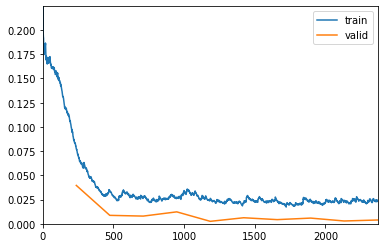

In [ ]:
learner.fit_one_cycle(10, 1e-4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.74E-04


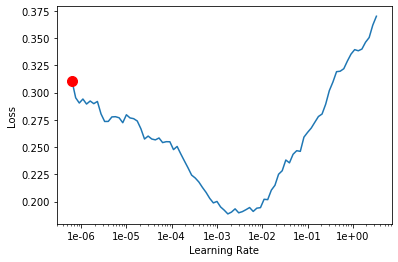

In [ ]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.127990,0.078381,6.615252,00:44
1,0.111057,0.076609,6.513234,00:44
2,0.087166,0.039984,4.804559,00:45
3,0.083744,0.051008,5.445715,00:45
4,0.080492,0.018674,3.251560,00:44
5,0.062334,0.015051,2.829041,00:45
6,0.055084,0.017188,3.039391,00:44
7,0.049574,0.013394,2.571294,00:44
8,0.042499,0.007814,1.933666,00:44
9,0.045577,0.007640,1.901253,00:45


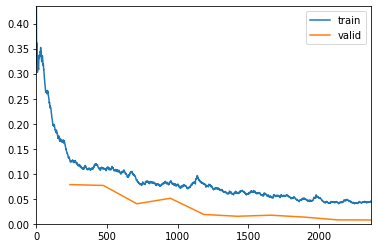

In [ ]:
learner.fit_one_cycle(10, 1e-4)

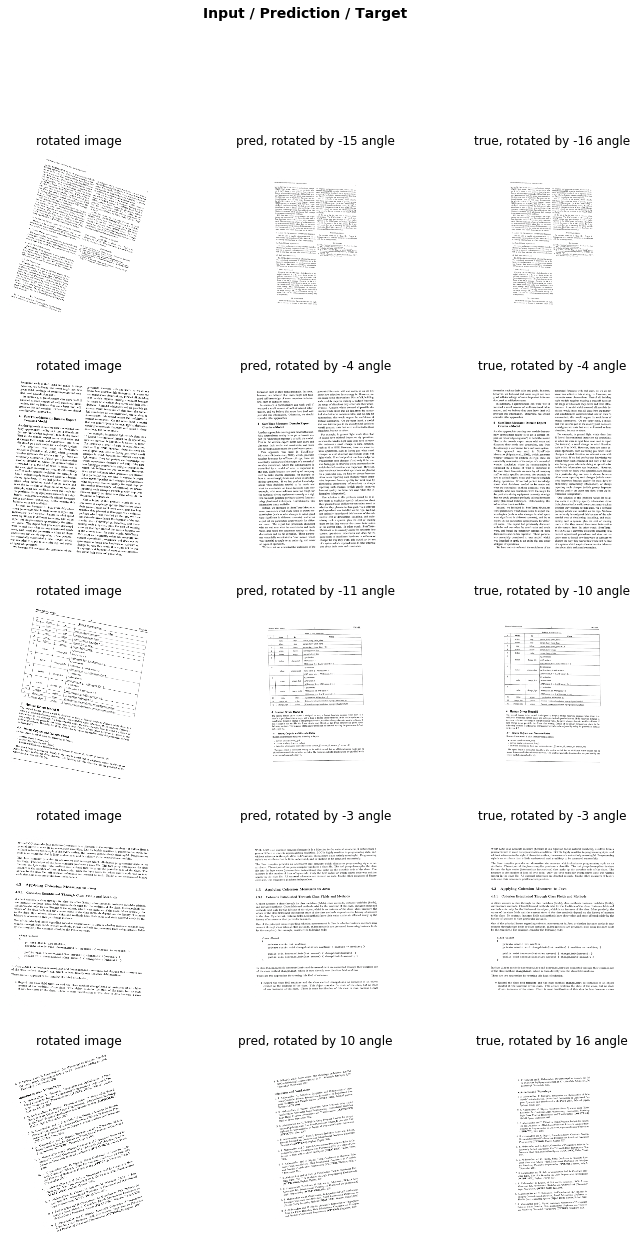

In [ ]:
learner.show_results()

In [ ]:
save_inference(learner, 'angle_predictor')

In [ ]:
learner.unfreeze()

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.044459,0.013119,2.687989,00:44
1,0.045040,0.012025,2.429124,00:44
2,0.050412,0.033613,4.081553,00:44
3,0.043044,0.006407,1.672823,00:45
4,0.036779,0.008995,2.152976,00:45
5,0.043500,0.010054,2.276195,00:44
6,0.026758,0.010974,2.256694,00:44
7,0.029416,0.008784,2.122927,00:45
8,0.028434,0.009069,2.085516,00:45
9,0.024298,0.011354,2.300901,00:44


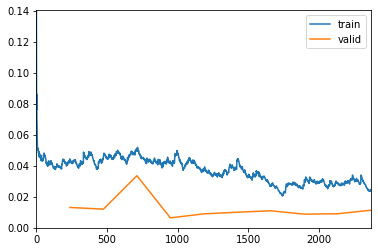

In [ ]:
learner.fit_one_cycle(10, 1e-4)

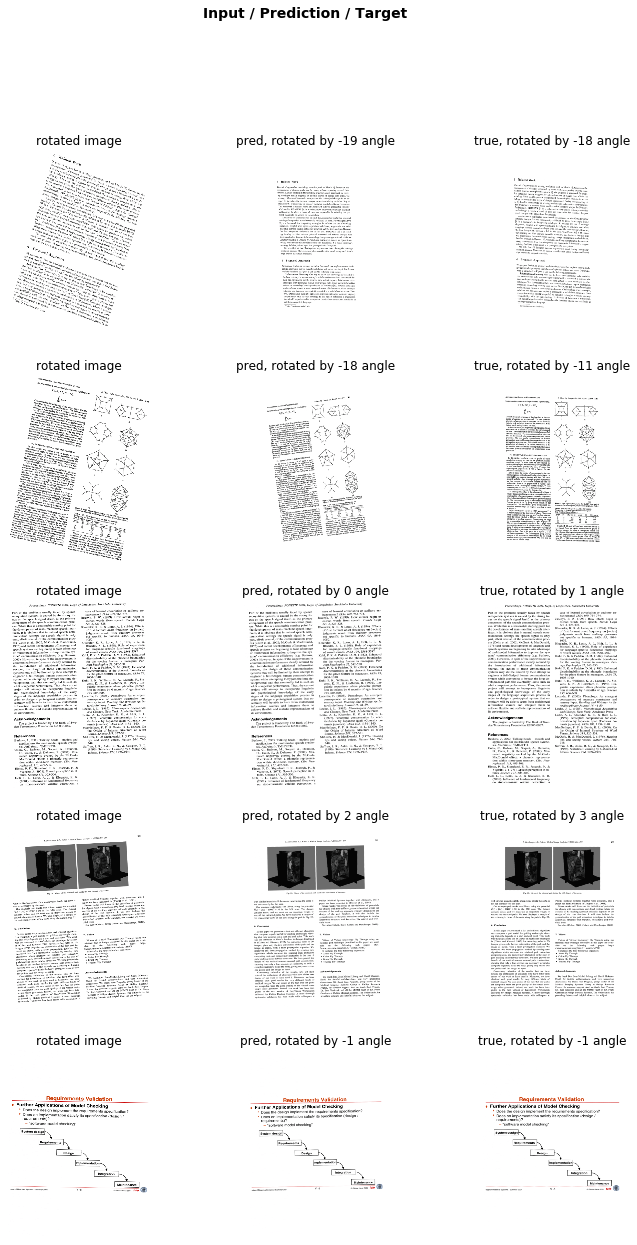

In [ ]:
learner.show_results(DatasetType.Train)

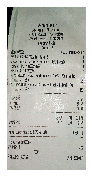

In [ ]:
im = cv2.imread('../test_data/cekis_cropped.jpg')
image = Image(tensor(im).permute(2,0,1).float() / 255.)
image.show()

In [ ]:
save_inference(learner, 'angle_predictor')

In [ ]:
learner = load_inference('angle_predictor')
learner.data = data

In [ ]:
def predict(self, item:ItemBase, return_x:bool=False, batch_first:bool=True, with_dropout:bool=False, **kwargs):
    "Return predicted class, label and probabilities for `item`."
    self.model.eval()
    batch = listify(self.data.one_item(item))
    batch[0] = batch[0].float()
    res = self.pred_batch(batch=batch, with_dropout=with_dropout)
    raw_pred,x = grab_idx(res,0,batch_first=batch_first),batch[0]
    norm = getattr(self.data,'norm',False)
    if norm:
        x = self.data.denorm(x)
        if norm.keywords.get('do_y',False): raw_pred = self.data.denorm(raw_pred)
    ds = self.data.single_ds
    pred = ds.y.analyze_pred(raw_pred, **kwargs)
    x = ds.x.reconstruct(grab_idx(x, 0))
    y = ds.y.reconstruct(pred, x) if has_arg(ds.y.reconstruct, 'x') else ds.y.reconstruct(pred)
    return (x, y, pred, raw_pred) if return_x else (y, pred, raw_pred)

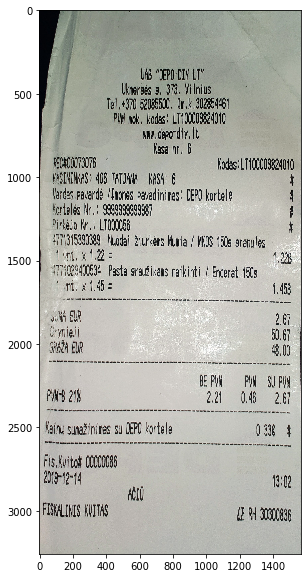

In [ ]:
plot(im, figsize=(10,10))

In [ ]:
def predict(self, item:ItemBase, return_x:bool=False, batch_first:bool=True, with_dropout:bool=False, **kwargs):
    "Return predicted class, label and probabilities for `item`."
    batch = listify(self.data.one_item(item))
    print(batch[0].shape)
    return self.model.eval()(batch[0].float())

In [ ]:
def deactivate_batchnorm(m):
    if isinstance(m, nn.BatchNorm2d):
        m.reset_parameters()
        m.eval()
        with torch.no_grad():
            m.weight.fill_(1.0)
            m.bias.zero_()

In [ ]:
learner.pred_batch??

In [ ]:
def predict(self, item:ItemBase, return_x:bool=False, batch_first:bool=True, with_dropout:bool=False, **kwargs):
    "Return predicted class, label and probabilities for `item`."
    self.model.eval()
    batch = listify(self.data.one_item(item))
    batch[0] = batch[0].float()
#     print(batch)
    res = self.model.eval()(batch[0])
#     res = self.pred_batch(batch=batch, with_dropout=with_dropout)
    print(res.shape)
#     self.model.apply(deactivate_batchnorm)
    print(res)
    raw_pred,x = grab_idx(res,0,batch_first=batch_first),batch[0]
    norm = getattr(self.data,'norm',False)
    if norm:
        x = self.data.denorm(x)
        if norm.keywords.get('do_y',False): raw_pred = self.data.denorm(raw_pred)
    ds = self.data.single_ds
    pred = ds.y.analyze_pred(raw_pred, **kwargs)
    x = ds.x.reconstruct(grab_idx(x, 0))
    y = ds.y.reconstruct(pred, x) if has_arg(ds.y.reconstruct, 'x') else ds.y.reconstruct(pred)
    return (x, y, pred, raw_pred) if return_x else (y, pred, raw_pred)

In [ ]:
def predict(self, item):
    batch = listify(self.data.one_item(item))
    print(batch)
    return self.model.eval()(batch[0].float())

In [ ]:
image.data.cpu()
predict(learner, image)

RuntimeError: CUDA out of memory. Tried to allocate 118.00 MiB (GPU 0; 7.80 GiB total capacity; 6.87 GiB already allocated; 112.00 MiB free; 121.90 MiB cached)

In [ ]:
learner.model.device

AttributeError: 'AffineMatrixPredictor' object has no attribute 'device'

In [ ]:
batch = learner.data.one_item(image)
learner.model.eval()(batch[0])

RuntimeError: Input type (torch.cuda.DoubleTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [ ]:
# learner.model.cuda()

In [ ]:
image.data.dtype

torch.float32

In [ ]:
learner.predict(image)

RuntimeError: Input type (torch.cuda.DoubleTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [ ]:
batch = self.learner.data.one_item(image)


In [ ]:
learner.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,0.116808,#na#,00:05
1,0.102789,#na#,00:05
2,0.144709,#na#,00:05
3,0.122509,#na#,00:05
4,0.142305,#na#,00:05
5,0.137878,#na#,00:05
6,0.119996,#na#,00:05
7,0.093433,#na#,00:05
8,0.090425,#na#,00:04
9,0.079626,#na#,00:05


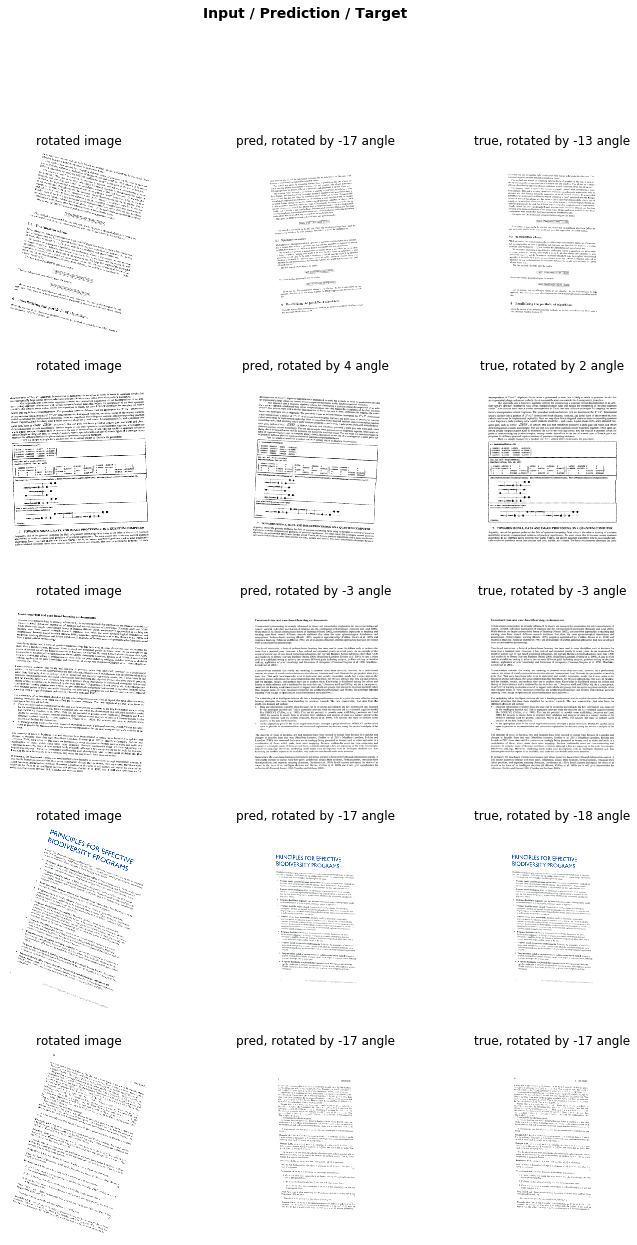

In [ ]:
learner.show_results(DatasetType.Train)

In [ ]:
data.train_ds

LabelList (4 items)
x: ImageTransformList
Image (3, 624, 480),Image (3, 624, 480),Image (3, 624, 480),Image (3, 624, 480)
y: MultiCategoryList
,,,
Path: ../data/dewarp/brno_templates

In [ ]:
doc(ImageList)

In [ ]:
doc(ItemList)

In [ ]:
doc(LabelList)

In [ ]:
class ImageTransformList(ImageList):
    "`ItemList` suitable for `Image` to `Image` tasks."
    _label_cls,_square_show,_square_show_res = ImageList,False,False

    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys`(targets)  on a figure of `figsize`."
        axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize)
        for i, (x,y) in enumerate(zip(xs,ys)):
            x.show(ax=axs[i,0], **kwargs)
            y.show(ax=axs[i,1], **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        title = 'Input / Prediction / Target'
        axs = subplots(len(xs), 3, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
        for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
            x.show(ax=axs[i,0], **kwargs)
            y.show(ax=axs[i,2], **kwargs)
            z.show(ax=axs[i,1], **kwargs)

### Spatial Transformer Transformation Example

In [ ]:
# [H,W,2] = F.affine_grid([B,2,3], tuple[4]), where tuple = (B,C,H,W)
# G = F.affine_grid(theta, tuple[4] ), where tuple = (B,C,H,W)

# [B,C,H,W] = F.grid_sample([B,C,H,W], [H,W,2])
# new_im = F.grid_sample(im, G)

In [ ]:
x = 1
y = 0
theta = 0
theta = torch.FloatTensor([
    [[np.cos(theta), -np.sin(theta), x],
     [np.sin(theta), np.cos(theta), y]]
])
print(theta.shape)
size = (1,1,100,200)
im = img.data # [0][None]
print(im.size())
size = (1,) + im.size()
G = F.affine_grid(theta, size)[0]
print(G.size())
# print(G[:, :, 0])
# print(G[:, :, 1])

torch.Size([1, 2, 3])
torch.Size([3, 1000, 724])
torch.Size([1000, 724, 2])


/home/dominykas/anaconda3/envs/nlp/lib/python3.7/site-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


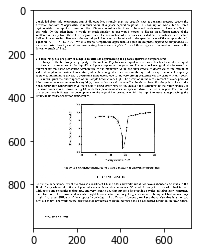

In [ ]:
plot(image2np(img.data))

In [ ]:
x = F.grid_sample(im[None], G[None])

/home/dominykas/anaconda3/envs/nlp/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


In [ ]:
x.shape

torch.Size([1, 3, 1000, 724])

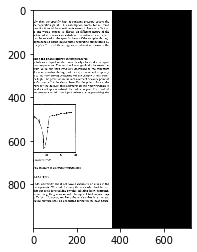

In [ ]:
plot(image2np(x[0]))

### Dataset

In [ ]:
def make_dataset(out_dir, size, num_elem=None): # size: tuple[2]
    im_paths = list(images_dir.iterdir())
    im_paths = im_paths if num_elem is None else im_paths[:num_elem]
    for im_path in progress_bar(im_paths):
        fn = str(im_path).split('/')[-1]
        im = open_image(im_path)
        im = im.resize((im.shape[0],) + size).refresh()
        im.save(out_dir/fn)

In [ ]:
w = 480
size = (int(w*1.3), w)

In [ ]:
make_dataset(train_dir, size, num_elem=4)

In [ ]:
train_transforms = [
#     crop_pad(),
    random_affine_transform(angle=(-20,20)),
#     symmetric_warp(magnitude=(-0.2, 0.2), p=1.),
#     rand_zoom(scale=(.2,.5), p=1.),
#     brightness(change=(0.4, 0.6), p=0.8),
#     contrast(scale=(0.8,1.2), p=0.8),
#     gaussian_blur(size=(1, 3), p=0.8)
]

valid_transforms = [
    random_affine_transform(angle=(-20,20))
#     rand_zoom(scale=(.5,.8), p=1.)
]
transforms = (train_transforms, valid_transforms)
# transforms = get_transforms()

In [ ]:
bs = 4
data = (ImageImageList.from_folder(train_dir)
#         .split_by_rand_pct(0.1, seed=42)
        .split_none()
        .label_from_func(lambda x:x)
        .transform(transforms, tfm_y=False)
        .databunch(bs=bs)
        .normalize(imagenet_stats, do_y=False))
data

ImageDataBunch;

Train: LabelList (4 items)
x: ImageImageList
Image (3, 624, 480),Image (3, 624, 480),Image (3, 624, 480),Image (3, 624, 480)
y: ImageList
Image (3, 624, 480),Image (3, 624, 480),Image (3, 624, 480),Image (3, 624, 480)
Path: ../data/dewarp/brno_templates;

Valid: LabelList (0 items)
x: ImageImageList

y: ImageList

Path: ../data/dewarp/brno_templates;

Test: None

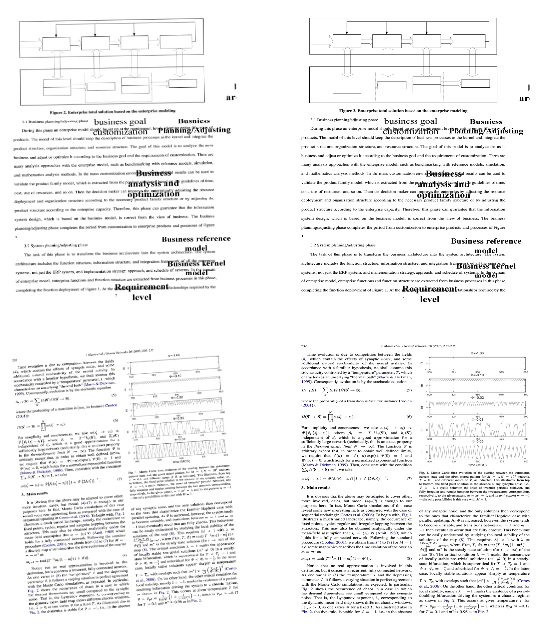

In [ ]:
data.show_batch(ds_type=DatasetType.Train, rows=2, figsize=(9,9))

### Model

In [ ]:
class LocalizationCNN(nn.Module):
    def __init__(self, nc):
        super().__init__()
        model = create_cnn_model(models.resnet18, nc=nc)
        self.body = model[0]
        self.head = model[1]
    
    def forward(self, x):
        x = self.body(x).detach()
        for name,f in self.head.named_children():
            if x.shape[0] == 1 and (name == '2' or name == '6'): continue
            x = f(x)
        return x

In [ ]:
torch.ones(1).expand(5)

tensor([1., 1., 1., 1., 1.])

In [ ]:
LocalizationCNN(3*2)(torch.zeros(2,3,100,100)).shape

torch.Size([2, 6])

In [ ]:
class SpatialTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        # Spatial transformer localization-network
        self.cnn = LocalizationCNN(nc=3*2)
        # Initialize the weights/bias with identity transformation
        self.cnn.head[-1].weight.data.zero_()
        self.cnn.head[-1].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def forward(self, x, align_corners=False):
        x = x.float()
        theta = self.cnn(x).view(-1, 2, 3) # [b,2,3]
        theta = torch.tanh(theta)
        grid = F.affine_grid(theta, x.size(), align_corners=align_corners)
        y = F.grid_sample(x, grid, align_corners=align_corners)
        return torch.sigmoid(y)

In [ ]:
SpatialTransformer()(torch.zeros(2,3,100,100)).shape

torch.Size([2, 3, 100, 100])

In [ ]:
class SpatialTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        # Spatial transformer localization-network
        self.cnn = LocalizationCNN(nc=1)
        self.cnn.head[-1].weight.data.zero_()
        self.cnn.head[-1].bias.data.copy_(torch.tensor([0], dtype=torch.float))

    def forward(self, x, align_corners=False):
        x = x.float()
        bs = x.shape[0]
        theta = self.cnn(x).view(-1, 1) # [b,2,3]
        theta = torch.tanh(theta)
        t1 =  torch.cos(theta.clone())
        t2 = -torch.sin(theta.clone())
        t3 =  torch.zeros(bs,1, dtype=theta.dtype, device=theta.device)
        t4 =  torch.sin(theta.clone())
        t5 =  torch.cos(theta.clone())
        t6 =  torch.zeros(bs,1, dtype=theta.dtype, device=theta.device)
        theta = torch.cat((t1,t2,t3,t4,t5,t6), dim=1)
        grid = F.affine_grid(theta.view(-1,2,3), x.size(), align_corners=align_corners)
        y = F.grid_sample(x, grid, align_corners=align_corners)
        return torch.sigmoid(y)

In [ ]:
SpatialTransformer()(torch.randn(2,3,100,100)).shape

torch.Size([2, 3, 100, 100])

### Feature Loss

In [ ]:
t = data.train_ds[0][1].data
t = torch.stack([t,t])
t.shape

torch.Size([2, 3, 624, 480])

In [ ]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [ ]:
gram_matrix(t).shape

torch.Size([2, 3, 3])

In [ ]:
from torchvision.models import vgg16_bn
base_loss = F.l1_loss
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [ ]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [ ]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [ ]:
feat_loss = FeatureLoss(vgg_m, blocks, [5,4,3,2,1])

### Training

In [ ]:
model = SpatialTransformer()

def loss(y_pred, y_true):
#     print(y_pred.max(), y_pred.min(), y_true.max(), y_true.min())
    return MSELossFlat()(y_pred, y_true)

loss = feat_loss
# loss = MSELossFlat()
learner = Learner(data, model, loss_func=loss, callback_fns=[ShowGraph], metrics=[], path='')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-05
Min loss divided by 10: 6.31E-08


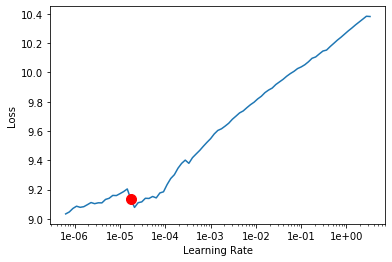

In [ ]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [ ]:
learner.fit_one_cycle(100, 1e-6)

epoch,train_loss,valid_loss,time
0,9.487102,#na#,00:01
1,8.329419,#na#,00:00
2,8.656793,#na#,00:00
3,8.890777,#na#,00:00
4,9.005117,#na#,00:00
5,9.043705,#na#,00:00
6,9.048198,#na#,00:00
7,9.090129,#na#,00:00
8,9.108849,#na#,00:01
9,9.130106,#na#,00:00


KeyboardInterrupt: 

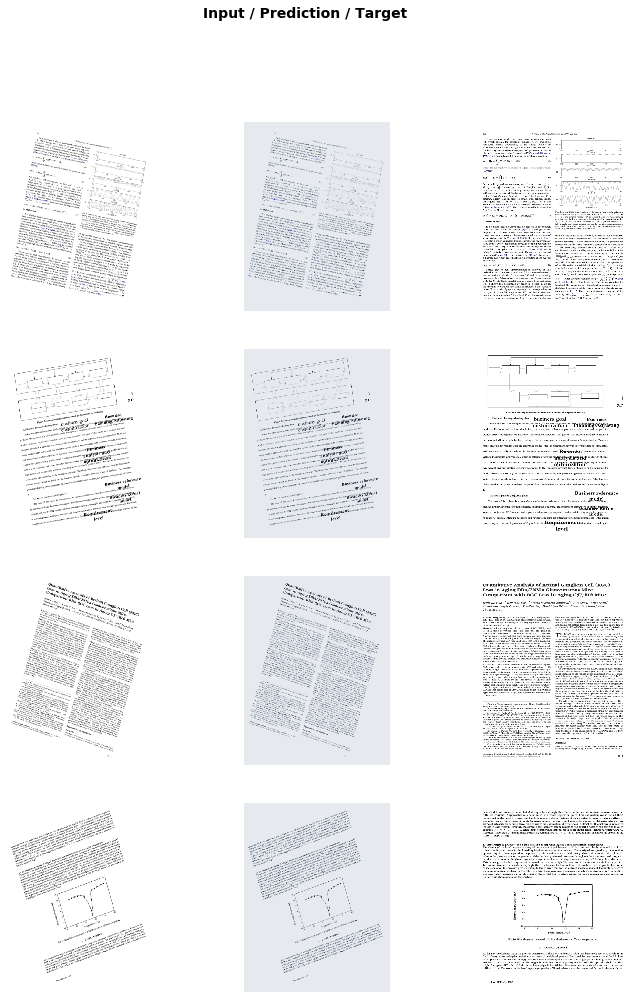

In [ ]:
learner.show_results(DatasetType.Train)

In [ ]:
class SpatialTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        print(xs.shape)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        print(theta.shape)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)
        return F.tanh(x)

In [ ]:
SpatialTransformer()(torch.zeros(2,3,28,28)).shape

torch.Size([2, 10, 3, 3])
torch.Size([2, 6])


torch.Size([2, 3, 28, 28])

In [ ]:
F.softmax()

TypeError: softmax() missing 1 required positional argument: 'input'

In [ ]:
x = 1
y = 0
theta = 0
theta = torch.FloatTensor([
    [[np.cos(theta), -np.sin(theta), x],
     [np.sin(theta), np.cos(theta), y]]
])
G = F.affine_grid(theta, torch.Size((1, 1, 100, 200)))[0]
print(G.size())
print(G[:, :, 0])
print(G[:, :, 1])

torch.Size([100, 200, 2])
tensor([[0.0000, 0.0101, 0.0201,  ..., 1.9799, 1.9899, 2.0000],
        [0.0000, 0.0101, 0.0201,  ..., 1.9799, 1.9899, 2.0000],
        [0.0000, 0.0101, 0.0201,  ..., 1.9799, 1.9899, 2.0000],
        ...,
        [0.0000, 0.0101, 0.0201,  ..., 1.9799, 1.9899, 2.0000],
        [0.0000, 0.0101, 0.0201,  ..., 1.9799, 1.9899, 2.0000],
        [0.0000, 0.0101, 0.0201,  ..., 1.9799, 1.9899, 2.0000]])
tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-0.9798, -0.9798, -0.9798,  ..., -0.9798, -0.9798, -0.9798],
        [-0.9596, -0.9596, -0.9596,  ..., -0.9596, -0.9596, -0.9596],
        ...,
        [ 0.9596,  0.9596,  0.9596,  ...,  0.9596,  0.9596,  0.9596],
        [ 0.9798,  0.9798,  0.9798,  ...,  0.9798,  0.9798,  0.9798],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]])


In [ ]:
img.data

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [ ]:
F.grid_sample(x, grid)